## Data preparation and sanitization

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb
import imblearn

# Read and sanitize the data
df = pd.read_excel("../data/UG_HH_NEW_continuous_no200.xls")
#df = pd.read_excel("./UG_HH_NEW_categorical_no200.xls")

df_effort = df[['time_spent_prop', 'count_effort']]
df_effort = (df_effort - df_effort.min()) / (df_effort.max() - df_effort.min())

df['effort'] = df_effort['time_spent_prop'] * df_effort['count_effort']
df = df[['time_spent_risk', 'cells', 'selfish', 'effort',
         'Honesty_Humility','Extraversion', 'Agreeableness', 'min_offer']]

df = df[['selfish','Honesty_Humility','Extraversion', 'Agreeableness', 'min_offer']]
df = df.dropna()

NORMALISE_DATA = True


x = df.values[:, :-1]
y = df.values[:, -1:]

if NORMALISE_DATA:
    x_min = x.min(axis=0)
    x_max = x.max(axis=0)
    x = (x - x_min) / (x_max - x_min)
    
NB_FEATURES = x.shape[1]

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 1/3, random_state = 0)

## Linear regression (continuous dataset)

**Accuracy / Loss - For model comparison**

In [2]:
MAX_GAIN = 200

def loss(min_offer, predicted):
    """
    Compute loss for the ultimatum game,
    as the difference between the possible gain and the actual one
    """
    min_offer = min_offer.ravel()
    predicted = predicted.ravel()
    rejected = min_offer > predicted
    res = predicted - min_offer
    if rejected.sum() != 0:
        res[rejected] = MAX_GAIN - min_offer[rejected]
    bad_predictions = (predicted < 0) | (predicted > MAX_GAIN)
    if bad_predictions.sum() != 0:
        res[bad_predictions] = MAX_GAIN - min_offer[bad_predictions]
    return res

def loss_sum(min_offer, predicted):
    return loss(min_offer, predicted).sum()

def avg_loss(min_offer, predicted):
    """
    Compute avg loss for the ultimatum game
    """
    return np.mean(loss(min_offer, predicted))

def mse(min_offer, predicted):
    """
    Compute mse using the loss as error
    """
    return np.mean(np.square(loss(min_offer, predicted)))

def rejection_ratio(min_offer, predicted):
    """
    Compute ratio of rejected proposals without consideration of values
    """
    accepted = (min_offer <= predicted)
    return 1 - np.mean(accepted)

def avg_win_loss(min_offer, predicted):
    """
    Compute avg_loss of accepted proposals
    """
    min_offer = min_offer.ravel()
    predicted = predicted.ravel()
    accepted = (min_offer <= predicted)
    if accepted.sum() == 0:
        return 0
    return avg_loss(min_offer[accepted], predicted[accepted])


def gain(min_offer, predicted):
    min_offer = min_offer.ravel()
    predicted = predicted.ravel()    
    res = MAX_GAIN - predicted
    res[predicted < min_offer] = 0
    return res

def avg_loss_ratio(min_offer, predicted):
    """
    Compute the avg gain ratio in relation to the maximal gain
    """
    return 1 - np.mean(gain(min_offer, predicted) / gain(min_offer, min_offer))


#### Benchmark

In [3]:
benchmark_functions = [avg_loss, mse, rejection_ratio, avg_win_loss, avg_loss_ratio, loss_sum]

from sklearn.model_selection import KFold
import numpy as np

def process_model(model, xTrain, yTrain, xTest, yTest, fit_kwargs=None, predict_kwargs=None):
    fit_kwargs = {} if fit_kwargs is None else fit_kwargs
    predict_kwargs = {} if predict_kwargs is None else predict_kwargs
    model.fit(xTrain, yTrain, **fit_kwargs)
    yPredict = model.predict(xTest, **predict_kwargs)
    results = {func.__name__: func(yTest, yPredict) for func in benchmark_functions}
    return results
    
def process_benchmark_cv(model, X, y, cv=5, metrics=None, fit_kwargs=None, predict_kwargs=None, augment_kwargs=None):
    # We make sure original values aren't modified, even by mistake
    X = np.copy(X)
    y = np.copy(y)
    
    kf = KFold(n_splits=cv)
    results = []
    for train_index, test_index in kf.split(X):
        xTrain, yTrain = X[train_index], y[train_index]
        if augment_kwargs:
            xTrain, yTrain = DACombine().fit_predict(xTrain, yTrain, **augment_kwargs)
        xTest, yTest = X[test_index], y[test_index]
        benchmark_result = process_model(model, xTrain, yTrain, xTest, yTest, fit_kwargs, predict_kwargs)
        results.append(benchmark_result)
    return pd.DataFrame(results)

** Data augmentation **

In [136]:
class DACombine(object):
    def __init__(self, size=None, nb_features=NB_FEATURES, max_gain=MAX_GAIN):
        self.size = size
        self.nb_features = nb_features
        self.max_gain = max_gain
    
    def fit_predict(self, xTrain, yTrain, size=None, distance=10, upsample=True, include_xy=False, retarget=False):
        """
        :param size: (int) size of the new generated dataset
        :param distance: (int) distance between parents or similar items
        :param upsample: (bool) if True, try balance the dataset
        :param include_xy: (bool) if True, include xTrain and yTrain to the data (on top of size items)
        :param retarget: (bool) if True, set all targets to the nearest higher multiple of distance without generating new samples
        """
        if retarget:
            return self.retarget(xTrain, yTrain, distance)
        size = size or self.size or len(xTrain) * 4
        indices = np.arange(self.nb_features)
        np.random.shuffle(indices)
        targets = yTrain.ravel()
        if upsample:
            targets, counts = np.unique(yTrain, return_counts=True)
            #NOTE: minimize selection of target with only one sample
            probs = (1 - counts/counts.sum())**2
            probs[counts==1] = probs.min()
            probs /= probs.sum()
        else:
            targets = yTrain.ravel()
            probs = None
        xRes = []
        yRes = []
        if include_xy:
            xRes.extend(xTrain)
            yRes.extend(yTrain)
        for _ in range(size):
            target = np.random.choice(targets, p=probs)
            target_mask = (yTrain.ravel()<target+distance) & (yTrain.ravel()>=(target))
            xTrain_target = xTrain[target_mask]
            i = np.random.randint(xTrain_target.shape[0])
            j = np.random.randint(xTrain_target.shape[0])
            x = np.zeros_like(xTrain_target[0])
            np.random.shuffle(indices)
            split = np.random.randint(self.nb_features)
            mask_i = indices[:split]
            mask_j = indices[split:]
            x[mask_i] = xTrain_target[i, mask_i]
            x[mask_j] = xTrain_target[j, mask_j]
            xRes.append(x)
            yRes.append(target)
        return np.array(xRes), np.array(yRes)

    def retarget(self, xTrain, yTrain, distance=10):
        yNew = np.zeros(yTrain.shape[0])
        for y in np.arange(self.max_gain, 0, -distance):
            mask = (yTrain <= y) & (yTrain > y-distance)
            yNew[mask] = y + distance
        yNew = np.array(yNew)
        yNew[yNew > self.max_gain] = self.max_gain
        return xTrain, yNew

    def fit_resample(self, xTrain, yTrain, size=None, distance=5, include_xy=True):
        return self.fit_predict(xTrain, yTrain, size=size, distance=distance, include_xy=include_xy)

In [75]:
#keras
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import multiply
from keras.wrappers.scikit_learn import KerasRegressor
import keras.backend as K
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
import sys


def sigmoid1024_tf(x):
    return (1024**x) / (1024**x + 1)

def sigmoid_tf(x):
    return K.sigmoid(x)

def gain_tf(y_true, y_pred):
    math_pi = tf.constant(math.pi)
    one = tf.constant(1.0)
    ten = tf.constant(10.0)
    x = tf.math.subtract(y_true, y_pred)
    x = tf.math.truediv(x, ten)
    left_mul = sigmoid_tf(x)
    right_mul = tf.math.cos(tf.math.divide(x, math_pi))
    return tf.math.multiply(left_mul, right_mul)


def loss_tf(y_true, y_pred):
    math_pi = tf.constant(math.pi)
    one = tf.constant(1.0)
    ten = tf.constant(10.0)
    x0 = tf.math.subtract(y_true, y_pred)
    x = tf.math.truediv(x0, ten)
    left_mul = sigmoid_tf(x)
    right_mul = tf.math.cos(tf.math.divide(x, math_pi))
    return tf.math.subtract(one*2, tf.math.multiply(left_mul, right_mul))

def _keras_model(loss=None, metrics=None):
    """
    build a simple regression model
    :param loss: (str|callable, default: loss_tf)
    """
    if loss is None:
        loss = loss_tf
    if metrics is None:
        metrics = ["mse"]
    model = Sequential()
    model.add(Dense(8, input_dim=NB_FEATURES, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer='adam', metrics=metrics)
    return model

def _keras_linear_regression(loss=None, metrics=None):
    if loss is None:
        loss = "mse"
    if metrics is None:
        metrics = ["mse"]
    model = Sequential()
    model.add(Dense(1, input_dim=NB_FEATURES, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer='adam', metrics=metrics)
    return model

def keras_linear_regression(loss=None, metrics=None, nb_epoch=100, batch_size=32, verbose=False):
    build_fn = lambda : _keras_linear_regression(loss, metrics)
    return KerasRegressor(build_fn=build_fn, epochs=nb_epoch, batch_size=batch_size, verbose=verbose)
    
def keras_model(loss=None, metrics=None, nb_epoch=100, batch_size=32, verbose=False):
    build_fn = lambda : _keras_model(loss, metrics)
    return KerasRegressor(build_fn=build_fn, epochs=nb_epoch, batch_size=batch_size, verbose=verbose)

**Linear regression**

(array([ 4,  5, 28, 13, 26, 38,  1,  3,  0,  1]),
 array([  0. ,  19.5,  39. ,  58.5,  78. ,  97.5, 117. , 136.5, 156. ,
        175.5, 195. ]))

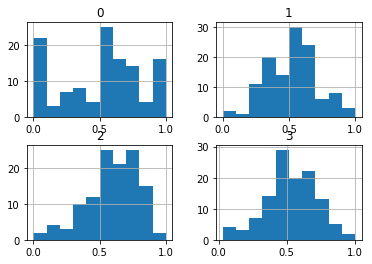

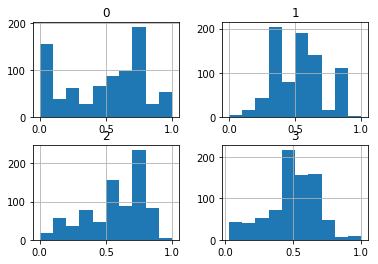

In [6]:
import imblearn
import imblearn.over_sampling
o_s = imblearn.over_sampling.RandomOverSampler()
xTrain_a, yTrain_a = o_s.fit_resample(xTrain, yTrain.ravel(), )
pd.DataFrame(xTrain).hist()
pd.DataFrame(xTrain_a).hist()
np.histogram(yTrain)

In [156]:
from sklearn.linear_model import LinearRegression, BayesianRidge, LogisticRegression, PassiveAggressiveRegressor, \
                                 ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble.bagging import BaggingRegressor, DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor
benchmark_models = {
    'base_model': SVC(gamma='auto'), #LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto'), #keras_linear_regression(nb_epoch=100, batch_size=60)
    'base_model2': LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto'),
}
    
augment_params = {
    'base': {},
    'retarget': {'retarget': True, 'distance': 10},
    'x0.5': {'size':len(xTrain//2)},
    'x0.5-up': {'size':len(xTrain//2), 'upsample': True},
    'x2': {'size':len(xTrain)*2},
    'x2-up': {'size':len(xTrain)*2, 'upsample': True},
    'x2+xy': {'size':len(xTrain)*2, 'include_xy':True},
    'x4': {'size': len(xTrain)*4},
    'x4+xy-up': {'size': len(xTrain)*4, 'include_xy':True, 'upsample':True},
    'x16': {'size': len(xTrain)*16},
}

results = {}
for key, model in benchmark_models.items():
    for aug_key, aug_params in augment_params.items():
        results[key+"_" + aug_key] = process_benchmark_cv(model=model, X=x, y=y.ravel(), augment_kwargs=aug_params)

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
pd.DataFrame(results_mean).T

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
base_model2_base,26.913492,0.219422,23.429033,963.0,1543.257937,0.072540
base_model2_retarget,36.340476,0.296365,33.422078,1301.0,2127.146825,0.072381
base_model2_x0.5,84.617460,0.737879,43.130749,3028.0,9159.571429,0.615079
base_model2_x0.5-up,75.934127,0.650801,50.541558,2712.0,7767.250000,0.426190
base_model2_x16,81.806349,0.711884,49.539825,2929.0,8704.404762,0.535873
base_model2_x2,82.365873,0.713664,50.362710,2950.0,8780.059524,0.546984
base_model2_x2+xy,44.838095,0.379353,24.663884,1605.0,4143.555556,0.251270
base_model2_x2-up,77.103175,0.680803,40.756089,2759.0,7920.682540,0.530476
base_model2_x4,83.088889,0.703676,50.606380,2972.0,9004.984127,0.503016
base_model2_x4+xy-up,62.719048,0.542197,33.616445,2246.0,6242.436508,0.384762


** Actual best model:**
- LogisticRegression (penalty='l1')

** Data Augmentation improve following models:**
- BaggingRegression
- MLPRegressor

In [154]:
model = benchmark_models['base_model2']

xx = model.predict(xTrain)
avg_loss_ratio(yTrain, xx)
#xx

0.36276570410968645

In [78]:
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import L1L2

reg = L1L2(l1=0.01, l2=0.01)
model = Sequential()
model.add(Dense(1, activation='relu', input_dim=x.shape[1]),)# W_regularizer=reg,)
model.compile(optimizer='adam', loss='mse', metrics=[gain_tf])
xTrain_a, yTrain_a = DACombine().fit_predict(xTrain, yTrain, size=1024)
history = model.fit(xTrain_a, yTrain_a, nb_epoch=500, validation_split=0.25)


/home/franck/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # Remove the CWD from sys.path while we load stuff.


Train on 768 samples, validate on 256 samples
Epoch 1/500
768/768 [==============================] - 10s 12ms/step - loss: 7135.0353 - gain_tf: -0.2213 - val_loss: 6919.0018 - val_gain_tf: -0.1427
Epoch 2/500
768/768 [==============================] - 0s 341us/step - loss: 7125.8420 - gain_tf: -0.2209 - val_loss: 6909.2886 - val_gain_tf: -0.1421
Epoch 3/500
768/768 [==============================] - 0s 347us/step - loss: 7116.1673 - gain_tf: -0.2204 - val_loss: 6899.1671 - val_gain_tf: -0.1415
Epoch 4/500
768/768 [==============================] - 0s 334us/step - loss: 7105.7088 - gain_tf: -0.2198 - val_loss: 6888.3478 - val_gain_tf: -0.1409
Epoch 5/500
768/768 [==============================] - 0s 345us/step - loss: 7094.6940 - gain_tf: -0.2194 - val_loss: 6877.2191 - val_gain_tf: -0.1402
Epoch 6/500
768/768 [==============================] - 0s 328us/step - loss: 7083.2792 - gain_tf: -0.2189 - val_loss: 6865.9434 - val_gain_tf: -0.1396
Epoch 7/500
768/768 [===========================

768/768 [==============================] - 0s 304us/step - loss: 6580.0421 - gain_tf: -0.1975 - val_loss: 6374.1206 - val_gain_tf: -0.1133
Epoch 55/500
768/768 [==============================] - 0s 357us/step - loss: 6570.0798 - gain_tf: -0.1970 - val_loss: 6364.3969 - val_gain_tf: -0.1128
Epoch 56/500
768/768 [==============================] - 0s 332us/step - loss: 6560.1179 - gain_tf: -0.1966 - val_loss: 6354.6959 - val_gain_tf: -0.1123
Epoch 57/500
768/768 [==============================] - 0s 288us/step - loss: 6550.2072 - gain_tf: -0.1961 - val_loss: 6344.9468 - val_gain_tf: -0.1117
Epoch 58/500
768/768 [==============================] - 0s 339us/step - loss: 6540.2926 - gain_tf: -0.1957 - val_loss: 6335.1924 - val_gain_tf: -0.1112
Epoch 59/500
768/768 [==============================] - 0s 333us/step - loss: 6530.3428 - gain_tf: -0.1953 - val_loss: 6325.5583 - val_gain_tf: -0.1107
Epoch 60/500
768/768 [==============================] - 0s 321us/step - loss: 6520.4615 - gain_tf: -0

Epoch 108/500
768/768 [==============================] - 0s 308us/step - loss: 6062.2378 - gain_tf: -0.1737 - val_loss: 5868.8024 - val_gain_tf: -0.0859
Epoch 109/500
768/768 [==============================] - 0s 316us/step - loss: 6053.0388 - gain_tf: -0.1733 - val_loss: 5859.8146 - val_gain_tf: -0.0854
Epoch 110/500
768/768 [==============================] - 0s 319us/step - loss: 6043.8062 - gain_tf: -0.1728 - val_loss: 5850.8944 - val_gain_tf: -0.0849
Epoch 111/500
768/768 [==============================] - 0s 321us/step - loss: 6034.6642 - gain_tf: -0.1724 - val_loss: 5841.8707 - val_gain_tf: -0.0845
Epoch 112/500
768/768 [==============================] - 0s 306us/step - loss: 6025.4873 - gain_tf: -0.1719 - val_loss: 5832.8612 - val_gain_tf: -0.0840
Epoch 113/500
768/768 [==============================] - 0s 333us/step - loss: 6016.2280 - gain_tf: -0.1715 - val_loss: 5824.0809 - val_gain_tf: -0.0835
Epoch 114/500
768/768 [==============================] - 0s 331us/step - loss: 600

768/768 [==============================] - 0s 325us/step - loss: 5590.6254 - gain_tf: -0.1504 - val_loss: 5409.9719 - val_gain_tf: -0.0610
Epoch 162/500
768/768 [==============================] - 0s 334us/step - loss: 5582.0972 - gain_tf: -0.1500 - val_loss: 5401.5405 - val_gain_tf: -0.0606
Epoch 163/500
768/768 [==============================] - 0s 325us/step - loss: 5573.4474 - gain_tf: -0.1495 - val_loss: 5393.3109 - val_gain_tf: -0.0601
Epoch 164/500
768/768 [==============================] - 0s 309us/step - loss: 5564.9068 - gain_tf: -0.1491 - val_loss: 5385.0633 - val_gain_tf: -0.0597
Epoch 165/500
768/768 [==============================] - 0s 372us/step - loss: 5556.4336 - gain_tf: -0.1487 - val_loss: 5376.6657 - val_gain_tf: -0.0592
Epoch 166/500
768/768 [==============================] - 0s 313us/step - loss: 5547.8584 - gain_tf: -0.1482 - val_loss: 5368.3785 - val_gain_tf: -0.0588
Epoch 167/500
768/768 [==============================] - 0s 290us/step - loss: 5539.3455 - gain_

768/768 [==============================] - 0s 299us/step - loss: 5151.7983 - gain_tf: -0.1273 - val_loss: 4984.6339 - val_gain_tf: -0.0383
Epoch 215/500
768/768 [==============================] - 0s 306us/step - loss: 5143.8589 - gain_tf: -0.1268 - val_loss: 4976.9041 - val_gain_tf: -0.0378
Epoch 216/500
768/768 [==============================] - 0s 328us/step - loss: 5135.9124 - gain_tf: -0.1264 - val_loss: 4969.1449 - val_gain_tf: -0.0374
Epoch 217/500
768/768 [==============================] - 0s 346us/step - loss: 5127.9196 - gain_tf: -0.1259 - val_loss: 4961.4834 - val_gain_tf: -0.0370
Epoch 218/500
768/768 [==============================] - 0s 337us/step - loss: 5120.0191 - gain_tf: -0.1255 - val_loss: 4953.7378 - val_gain_tf: -0.0366
Epoch 219/500
768/768 [==============================] - 0s 343us/step - loss: 5112.0186 - gain_tf: -0.1251 - val_loss: 4946.1627 - val_gain_tf: -0.0362
Epoch 220/500
768/768 [==============================] - 0s 325us/step - loss: 5104.1161 - gain_

768/768 [==============================] - 0s 324us/step - loss: 4744.3269 - gain_tf: -0.1042 - val_loss: 4591.0930 - val_gain_tf: -0.0175
Epoch 268/500
768/768 [==============================] - 0s 326us/step - loss: 4736.9400 - gain_tf: -0.1038 - val_loss: 4583.9961 - val_gain_tf: -0.0171
Epoch 269/500
768/768 [==============================] - 0s 325us/step - loss: 4729.5605 - gain_tf: -0.1033 - val_loss: 4576.9044 - val_gain_tf: -0.0168
Epoch 270/500
768/768 [==============================] - 0s 321us/step - loss: 4722.1684 - gain_tf: -0.1029 - val_loss: 4569.8767 - val_gain_tf: -0.0164
Epoch 271/500
768/768 [==============================] - 0s 351us/step - loss: 4714.8413 - gain_tf: -0.1025 - val_loss: 4562.7879 - val_gain_tf: -0.0160
Epoch 272/500
768/768 [==============================] - 0s 361us/step - loss: 4707.5060 - gain_tf: -0.1020 - val_loss: 4555.6753 - val_gain_tf: -0.0157
Epoch 273/500
768/768 [==============================] - 0s 331us/step - loss: 4700.1558 - gain_

768/768 [==============================] - 0s 281us/step - loss: 4367.6036 - gain_tf: -0.0812 - val_loss: 4229.1744 - val_gain_tf: 0.0014
Epoch 321/500
768/768 [==============================] - 0s 325us/step - loss: 4360.7838 - gain_tf: -0.0808 - val_loss: 4222.6181 - val_gain_tf: 0.0017
Epoch 322/500
768/768 [==============================] - 0s 310us/step - loss: 4353.9449 - gain_tf: -0.0804 - val_loss: 4216.1500 - val_gain_tf: 0.0021
Epoch 323/500
768/768 [==============================] - 0s 364us/step - loss: 4347.2022 - gain_tf: -0.0799 - val_loss: 4209.5743 - val_gain_tf: 0.0024
Epoch 324/500
768/768 [==============================] - 0s 304us/step - loss: 4340.3847 - gain_tf: -0.0795 - val_loss: 4203.0872 - val_gain_tf: 0.0027
Epoch 325/500
768/768 [==============================] - 0s 334us/step - loss: 4333.6011 - gain_tf: -0.0790 - val_loss: 4196.6281 - val_gain_tf: 0.0031
Epoch 326/500
768/768 [==============================] - 0s 328us/step - loss: 4326.8425 - gain_tf: -0

Epoch 374/500
768/768 [==============================] - 0s 311us/step - loss: 4014.9757 - gain_tf: -0.0578 - val_loss: 3892.1656 - val_gain_tf: 0.0192
Epoch 375/500
768/768 [==============================] - 0s 321us/step - loss: 4008.7156 - gain_tf: -0.0573 - val_loss: 3886.1956 - val_gain_tf: 0.0195
Epoch 376/500
768/768 [==============================] - 0s 330us/step - loss: 4002.4848 - gain_tf: -0.0569 - val_loss: 3880.2523 - val_gain_tf: 0.0198
Epoch 377/500
768/768 [==============================] - 0s 344us/step - loss: 3996.2499 - gain_tf: -0.0565 - val_loss: 3874.3543 - val_gain_tf: 0.0201
Epoch 378/500
768/768 [==============================] - 0s 348us/step - loss: 3990.0842 - gain_tf: -0.0560 - val_loss: 3868.3873 - val_gain_tf: 0.0205
Epoch 379/500
768/768 [==============================] - 0s 317us/step - loss: 3983.8251 - gain_tf: -0.0556 - val_loss: 3862.5790 - val_gain_tf: 0.0208
Epoch 380/500
768/768 [==============================] - 0s 318us/step - loss: 3977.6760

Epoch 428/500
768/768 [==============================] - 0s 318us/step - loss: 3693.3832 - gain_tf: -0.0342 - val_loss: 3586.7836 - val_gain_tf: 0.0361
Epoch 429/500
768/768 [==============================] - 0s 318us/step - loss: 3687.7147 - gain_tf: -0.0337 - val_loss: 3581.4157 - val_gain_tf: 0.0364
Epoch 430/500
768/768 [==============================] - 0s 320us/step - loss: 3682.0244 - gain_tf: -0.0333 - val_loss: 3576.1359 - val_gain_tf: 0.0367
Epoch 431/500
768/768 [==============================] - 0s 326us/step - loss: 3676.4340 - gain_tf: -0.0329 - val_loss: 3570.7578 - val_gain_tf: 0.0370
Epoch 432/500
768/768 [==============================] - 0s 372us/step - loss: 3670.7704 - gain_tf: -0.0324 - val_loss: 3565.4604 - val_gain_tf: 0.0373
Epoch 433/500
768/768 [==============================] - 0s 307us/step - loss: 3665.1790 - gain_tf: -0.0320 - val_loss: 3560.1144 - val_gain_tf: 0.0376
Epoch 434/500
768/768 [==============================] - 0s 306us/step - loss: 3659.5307

Epoch 482/500
768/768 [==============================] - 0s 336us/step - loss: 3402.4388 - gain_tf: -0.0105 - val_loss: 3312.7545 - val_gain_tf: 0.0526
Epoch 483/500
768/768 [==============================] - 0s 311us/step - loss: 3397.3177 - gain_tf: -0.0101 - val_loss: 3307.9660 - val_gain_tf: 0.0529
Epoch 484/500
768/768 [==============================] - 0s 311us/step - loss: 3392.2254 - gain_tf: -0.0097 - val_loss: 3303.1950 - val_gain_tf: 0.0532
Epoch 485/500
768/768 [==============================] - 0s 324us/step - loss: 3387.1731 - gain_tf: -0.0092 - val_loss: 3298.3770 - val_gain_tf: 0.0535
Epoch 486/500
768/768 [==============================] - 0s 330us/step - loss: 3382.0649 - gain_tf: -0.0088 - val_loss: 3293.6682 - val_gain_tf: 0.0538
Epoch 487/500
768/768 [==============================] - 0s 326us/step - loss: 3377.0432 - gain_tf: -0.0083 - val_loss: 3288.8938 - val_gain_tf: 0.0541
Epoch 488/500
768/768 [==============================] - 0s 321us/step - loss: 3371.9579

In [79]:
yPred = model.predict(xTest)


In [146]:
_, yy = DACombine().retarget(xTrain, yTrain.ravel(), 20)
#yy - yTrain.ravel()
yy


array([ 80., 120.,  60., 120., 180.,  80., 120., 100.,  80., 100., 180.,
       200.,  40., 120., 120.,  80., 100., 120., 100., 100.,  80.,  80.,
        60.,  80.,  60., 120.,  60., 120., 100., 100.,  60.,  80., 100.,
       120.,  40., 100., 100.,  80., 120., 100.,  80., 120.,  80., 120.,
        80., 120., 100., 120., 120., 100., 100., 120., 120., 120.,  80.,
        40.,  80., 160., 120.,  80., 140., 100., 140., 120., 120., 100.,
        80., 120.,  80.,  80., 120.,   0., 120.,  80., 120.,  80., 120.,
       120., 100., 100., 120., 100., 120., 120.,  80.,  80., 120., 100.,
        80.,  80., 120., 100.,  80., 120., 120., 120.,  40., 100., 120.,
       120.,  80., 180., 120., 120., 120., 120., 120., 120., 120., 100.,
       120.,  80., 100.,  60.,  60., 100., 120.,  80., 140.])